<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

z# Lab 3: Intro to CNNs and DNNs

## Objectives

* Build and train a deep conv net
* Explore and implement various initialization techniques
* Implement a parameterized module in Pytorch
* Use a principled loss function

## Video Tutorial
[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

## Deliverable
For this lab, you will submit an ipython notebook via learningsuite.
This is where you build your first deep neural network!

For this lab, we'll be combining several different concepts that we've covered during class,
including new layer types, initialization strategies, and an understanding of convolutions.

## Grading Standards:
* 30% Part 0: Successfully followed lab video and typed in code
* 20% Part 1: Re-implement Conv2D and CrossEntropy loss function
* 20% Part 2: Implement different initialization strategies
* 10% Part 3: Print parameters, plot train/test accuracy
* 10% Part 4: Convolution parameters quiz
* 10% Tidy and legible figures, including labeled axes where appropriate
___

### Part 0
Watch and follow video tutorial:

[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

**TODO:**


**DONE:**

* Watch tutorial

In [1]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

___

### Part 1
Re-implement a Conv2D module with parameters and a CrossEntropy loss function.

**TODO:**


**DONE:**

* CrossEntropyLoss 
* Conv2D
___



In [0]:
class CrossEntropyLoss(nn.Module):
    def __init__(self, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean'):
        super(CrossEntropyLoss, self).__init__()
        
    def forward(self, input, target):
        exp_input = torch.exp(input)
        nlog_input = -torch.log(exp_input/torch.sum(exp_input, axis=1,keepdim=True))
        loss = torch.mean(nlog_input)
        acc = torch.sum(torch.argmax(nlog_input,axis=1) == target)/(len(target) + 0.0)
        # pdb.set_trace()
        return loss, acc

class Conv2d(nn.Module):
    def __init__(self, in_channels, 
                 out_channels, 
                 kernel_size, 
                 stride=1, 
                 padding=0, 
                 dilation=1, 
                 groups=1,
                 bias=True,
                 xavier=False,
                 orthogonal=False,
                 uniform=False):
        
        self.__dict__.update(locals())
        super(Conv2d, self).__init__()

        self.weight = Parameter(torch.Tensor(out_channels,
                                             in_channels, 
                                             kernel_size[0],
                                             kernel_size[1]))
        

        self.bias = Parameter(torch.Tensor(out_channels))

        # Custom initialization (default)
        self.weight.data = torch.ones_like(self.weight.data)/2
        self.bias.data = torch.ones_like(self.bias.data)/2
        
        self.weight.data.uniform_(1/10,1/10)
        self.bias.data.uniform_(-1,1)
        

        # Xavier initialization
        if xavier:
            n = in_channels
            self.weight.data.normal_(0,np.sqrt(2/n))
            self.bias.data.uniform_(0,0)

        # Orthogonal initialization
        elif orthogonal:
            X = np.random.random((out_channels, 
                                  in_channels * kernel_size[0] * kernel_size[1]))
            
            U, _, Vt = np.linalg.svd(X, full_matrices=False)

            self.weight.data = torch.Tensor(Vt.reshape((out_channels,
                                                        in_channels, 
                                                        kernel_size[0],
                                                        kernel_size[1])))

        # Uniform initialization
        elif uniform:
            self.weight.data.uniform_(-1,1)
            self.bias.data.uniform_(0,0)
        
    def forward(self, x):
        return F.conv2d(x, self.weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)
        

class ConvNetwork(nn.Module):
    def __init__(self, dataset):
        super(ConvNetwork, self).__init__()
        x,y = dataset[0]
        c,h,w = x.size()
        output = 10
  
        self.net = nn.Sequential(
            Conv2d(c, 10, (3,3), padding=(1,1)),
            Conv2d(10, output, (28,28), padding=(0,0)),
            )

    def forward(self, x):
        return self.net(x).squeeze(2).squeeze(2)

class Xavier(nn.Module):
    def __init__(self, dataset):
        super(Xavier, self).__init__()
        x,y = dataset[0]
        c,h,w = x.size()
        output = 10
  
        self.net = nn.Sequential(
            Conv2d(c, 10, (3,3), padding=(1,1), xavier=True),
            Conv2d(10, output, (28,28), padding=(0,0), xavier=True),
            )

    def forward(self, x):
        return self.net(x).squeeze(2).squeeze(2)


class Orthogonal(nn.Module):
    def __init__(self, dataset):
        super(Orthogonal, self).__init__()
        x,y = dataset[0]
        c,h,w = x.size()
        output = 10
  
        self.net = nn.Sequential(
            Conv2d(c, 8, (3,3), padding=(1,1), orthogonal=True),
            Conv2d(8, output, (28,28), padding=(0,0), orthogonal=True),
            )

    def forward(self, x):
        return self.net(x).squeeze(2).squeeze(2)


class Uniform(nn.Module):
    def __init__(self, dataset):
        super(Uniform, self).__init__()
        x,y = dataset[0]
        c,h,w = x.size()
        output = 10
  
        self.net = nn.Sequential(
            Conv2d(c, 10, (3,3), padding=(1,1),uniform=True),
            Conv2d(10, output, (28,28), padding=(0,0),uniform=True),
            )

    def forward(self, x):
        return self.net(x).squeeze(2).squeeze(2)



In [0]:
# Initialize Datasets
class FashionMNISTProcessedDataset(Dataset):
    def __init__(self,root, train=True):
        self.data = datasets.FashionMNIST(root, 
                                          train=train,
                                          transform=transforms.ToTensor(), 
                                          download=True)
    
    def __getitem__(self,i):
        x,y = self.data[i]
        return x, y
    
    def __len__(self):
        return len(self.data)

train_dataset=FashionMNISTProcessedDataset('/tmp/fashionmnist', train=True)
val_dataset=FashionMNISTProcessedDataset('/tmp/fashionmnist', train=False)

train_loader=DataLoader(train_dataset, batch_size=42, pin_memory=True)
val_loader=DataLoader(val_dataset, batch_size=42, pin_memory=True)

plt_titles = ['Custom', 'Xavier', 'Orthogonal', 'Uniform']
accuracies = {title:[] for title in plt_titles}
# parameters = {title:0 for title in plt_titles}
def run_and_plot(epochs=2, plt_num=0,
                 objective=CrossEntropyLoss(),
                 model=ConvNetwork(train_dataset).cuda()
                 ):
    optimizer=optim.Adam(model.parameters(), lr=1e-4)

    # Run training / validation loops
    losses = []
    validations = []
    # params = np.prod([np.sum(p) for p in model.parameters()])
    # parameters[plt_titles[plt_num]] = params

    for epoch in range(epochs):
        loop = tqdm(total=len(train_loader), position=0)

        for batch, (x, y_truth) in enumerate(train_loader):
            x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)

            optimizer.zero_grad()
            y_hat = model(x).double()
            
            loss, accuracy = objective(y_hat, y_truth)
            # print(accuracy.item())
            accuracy = accuracy.item()
            accuracies[plt_titles[plt_num]].append(accuracy)
            loss.backward()

            losses.append(loss.item())
   
            loop.set_description('init:{}, epoch:{}, loss:{:.4f}, accuracy:{:.3f}'\
                                .format(plt_titles[plt_num], epoch, loss, accuracy))
            loop.update(1)
            optimizer.step()
            
            if batch % 50 == 0:
                val = np.mean([objective(model(x.cuda()),y.cuda())[0].item() \
                            for x,y in val_loader])
                validations.append((len(losses), val))

    loop.close()

    x,y = zip(*validations)
    plt.title(plt_titles[plt_num])
    plt.plot(losses, label='train')
    plt.plot(x,y,label='validation')
    plt.legend()
    plt.show()



### Part 2
Implement a few initialization strategies which can include Xe initialization
(sometimes called Xavier), Orthogonal initialization, and uniform random.
You can specify which strategy you want to use with a parameter. 



Helpful links include:
*  [Orthogonal Initialization](https://hjweide.github.io/orthogonal-initialization-in-convolutional-layers) (or the original paper: http://arxiv.org/abs/1312.6120)
*  http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization

**TODO:**

**DONE:**

* Parameterize custom Conv2D for different initialization strategies
* Xe
* Orthogonal
* Uniform

init:Custom, epoch:1, loss:nan, accuracy:0.083: 100%|██████████| 1429/1429 [00:47<00:00, 30.22it/s]


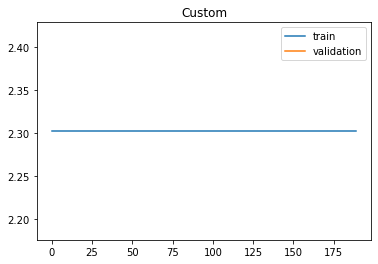

init:Xavier, epoch:1, loss:17.0714, accuracy:0.083: 100%|██████████| 1429/1429 [00:50<00:00, 28.48it/s]


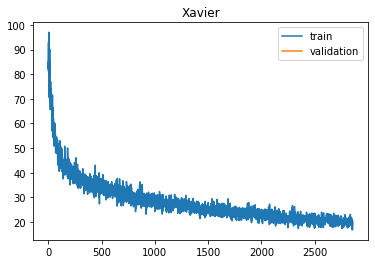

init:Orthogonal, epoch:1, loss:2.3026, accuracy:0.083: 100%|██████████| 1429/1429 [00:46<00:00, 31.06it/s]


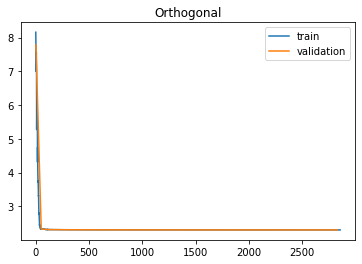

init:Uniform, epoch:1, loss:11.7009, accuracy:0.167: 100%|██████████| 1429/1429 [00:46<00:00, 30.86it/s]


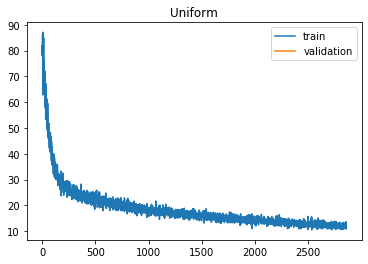

In [49]:

n = 2
#Custom -- w_k = 1/10 , b ~ Uniform([-1,1])
run_and_plot(epochs=n, model=ConvNetwork(train_dataset).cuda(), plt_num=0 )

#Xavier
run_and_plot(epochs=n, model=Xavier(train_dataset).cuda(), plt_num=1)

#Orthogonal
run_and_plot(epochs=n, model=Orthogonal(train_dataset).cuda(), plt_num=2)

#Uniform
run_and_plot(epochs=n, model=Uniform(train_dataset).cuda(), plt_num=3)



___

### Part 3
Print the number of parameters in your network and plot accuracy of your training and validation 
set over time. You should experiment with some deep networks and see if you can get a network 
with close to 1,000,000 parameters.

**TODO:**
* Print out number of parameters in the model 

**DONE:**
* Experiment with Deep Networks
* Plot accuracy of training and validation set over time


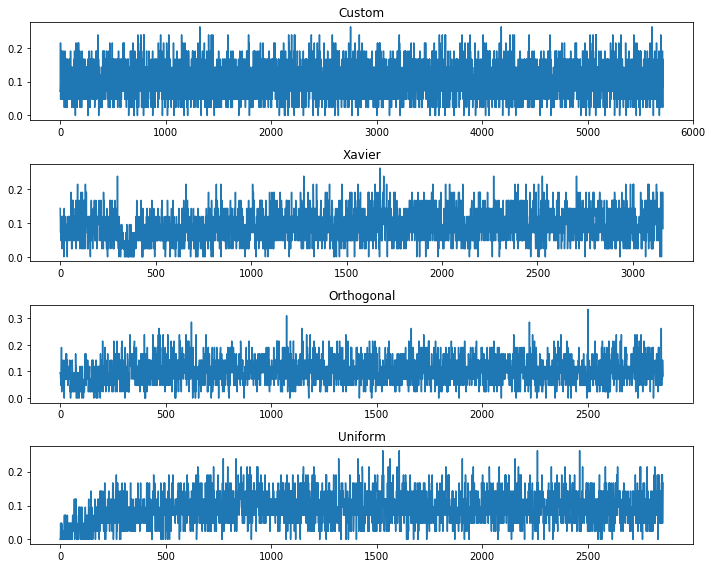

In [59]:

# Go back up and try a few different networks and initialization strategies
# Plot loss if you want
# Plot accuracy
fig, ax = plt.subplots(4,figsize=(10,8))
for i, k in enumerate(accuracies):
    ax[i].set_title(plt_titles[i])
    ax[i].plot(accuracies[k])
plt.tight_layout()

In [0]:
# Compute and print the number of parameters in the model


___

### Part 4
Learn about how convolution layers affect the shape of outputs, and answer the following quiz questions. Include these in a new markdown cell in your jupyter notebook.


*Using a Kernel size of 3×3 what should the settings of your 2d convolution be that results in the following mappings (first answer given to you)*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(3, 3), padding=(0, 0))
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=65, h=12, w=12) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=7, h=20, w=20) : **Your answer in bold here**

*Using a Kernel size of 5×5:*)

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 5), padding=(1, 1))
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **Your answer in bold here**

*Using Kernel size of 5×3:*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **Your answer in bold here**

*Determine the kernel that requires the smallest padding size to make the following mappings possible:*

* (c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **Your answer in bold here**

**TODO:**

* Answer all the questions above 

**DONE:**


In [0]:
# Write some test code for checking the answers for these problems (example shown in the video)
